In [1]:
import os, sys

In [2]:
base_dir = os.path.split(os.getcwd())[0]
os.chdir(os.path.join(base_dir,'core'))

In [15]:
import pickle as pk

import numpy as np
import cv2
import sys
import argparse
import time
import copy
import datetime
import yaml

import matplotlib.pyplot as plt

from utils import ARUCO_DICT, display_pose
from estimators import PoseSingle, PoseSpecial

In [4]:
from scipy.spatial.transform import Rotation as R

In [16]:
k_matrix = "../calib/calibration_matrix_render_calib.npy"
d_coeff = "../calib/distortion_coefficients_render_calib.npy"
m_dict = "../demo_tags/marker_poses.pk"
edge_len = 0.7
marker_step = 8
n_markers = 100

type_ = "DICT_7X7_100"

if ARUCO_DICT.get(type_, None) is None:
    print(f"ArUCo tag type '{type_}' is not supported")
    sys.exit(0)

aruco_dict_type = ARUCO_DICT[type_]
calibration_matrix_path = k_matrix
distortion_coefficients_path = d_coeff
marker_dict_path = m_dict


k = np.load(calibration_matrix_path)
d = np.load(distortion_coefficients_path)

# путь к конфигу с позициями маркеров
config_filename = "../jupyters/marker_poses.yaml"

# загрузка конфига
with open(config_filename, encoding='utf8') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

# нам нужен дикт
marker_poses = dict(
    zip([id for id in range(len(cfg['poses']))], 
        cfg['poses']))


with open(marker_dict_path,'rb') as f:
    marker_dict = pk.load(f)

estimator = PoseSingle(aruco_dict_type,
                       1,
                       n_markers,
                       marker_poses,
                       edge_len,
                       k,
                       d)

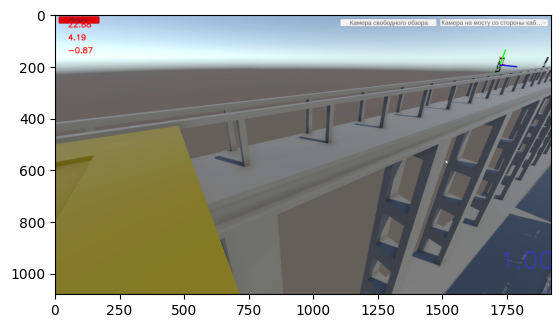

[[0.7875681646038621 -0.2277004081347645 0.5726158487483259
  22.882052780834325]
 [0.6137413679147521 0.3732240781649637 -0.6957192830359398
  4.192003593284826]
 [-0.05529845759723301 0.8993643931205944 0.4336885621897266
  -0.8678066115203532]
 [0.0 0.0 0.0 1.0]]


In [17]:
# Test on single image
image = "../data/render_distance/frames_front/481.png"

image = cv2.imread(image)
time.sleep(.1)

# output = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plt.imshow(output)
# plt.show()

frame, pose, size = estimator(image, True)

output = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

output = display_pose(output, pose[:-1,[3]])

plt.imshow(output)
plt.show()
print(pose)

486


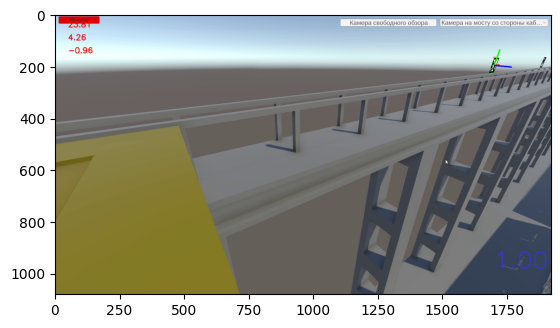

[[0.7897286962287595 -0.2333005313409805 0.5673618320162537
  23.812521242911025]
 [0.6116458114740251 0.37045377494673415 -0.6990374824957498
  4.264094182879349]
 [-0.04709551633759623 0.8990744478093738 0.43525526951108195
  -0.964821375809358]
 [0.0 0.0 0.0 1.0]]
487


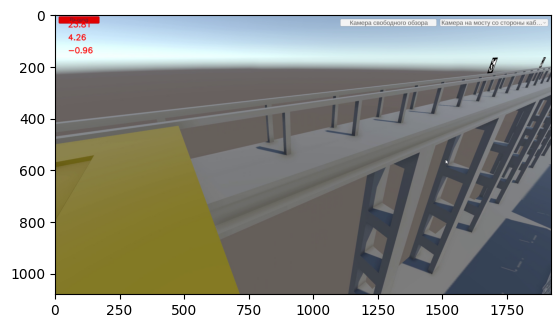

[[0.7897286962287595 -0.2333005313409805 0.5673618320162537
  23.812521968324916]
 [0.6116458114740251 0.37045377494673415 -0.6990374824957498
  4.264094182879349]
 [-0.04709551633759623 0.8990744478093738 0.43525526951108195
  -0.964821375809358]
 [0.0 0.0 0.0 1.0]]


In [18]:
# Test on multiple images
for i in range(486,488):
    print(i)
    image = cv2.imread(f"../data/render_distance/frames_front/{i}.png")
    time.sleep(.1)
    
    # output = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # plt.imshow(output)
    # plt.show()
    
    frame, pose, size = estimator(image, True)
    
    output = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    try:
        output = display_pose(output, pose[:-1,[3]])
    except: continue
    plt.imshow(output)
    plt.show()
    print(pose)
    

In [19]:
# Special estimator

type_ = "DICT_5X5_50"

if ARUCO_DICT.get(type_, None) is None:
    print(f"ArUCo tag type '{type_}' is not supported")
    sys.exit(0)

aruco_dict_type = ARUCO_DICT[type_]

special_estimator = PoseSpecial(
        aruco_dict_type = aruco_dict_type,
        # camera_orientation = 1,
        marker_id = 38,
        marker_edge_len = 0.8,
        matrix_coefficients = k,
        distortion_coefficients = d,
        # apply_kf = False,
        z_bias = 0,
        debug = False,
)

In [20]:
# Run on image
image_special = '../data/render_special/frames/1250.png'

image_special = cv2.imread(image_special)
time.sleep(.1)

output, pose = special_estimator(image_special, return_frame = True)

In [21]:
pose

masked_array(
  data=[[0.9998560256289797, -0.014068450048345654, 0.009487187499894368,
         -4.141167954434785],
        [-0.016966093539091415, -0.8381620788474233, 0.545157299549578,
         -3.5831035581334385],
        [0.00028228256012250395, -0.5452397713808145,
         -0.8382800916287785, 11.38410552258195],
        [0.0, 0.0, 0.0, 1.0]],
  mask=[[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],
  fill_value=1e+20)

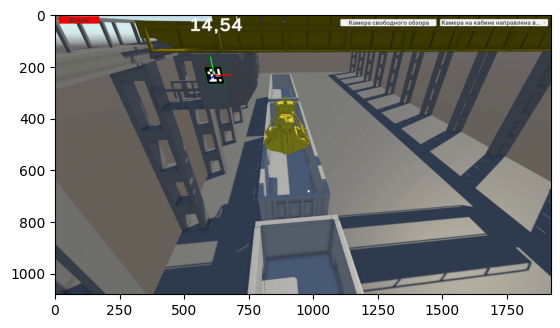

In [10]:
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(output)
plt.show()

In [11]:
# Run on video
source_fn = '../data/render_special/Nlmk_Build_special.mp4'
target_fn = '../data/render_special/Nlmk_Build_special.mov'

cap = cv2.VideoCapture(source_fn)

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)/10)
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

estimator_video = special_estimator

out = cv2.VideoWriter(target_fn, cv2.VideoWriter_fourcc('M','J','P','G'), 30, (width,height))

if (cap.isOpened()== False): 
  print("Error opening video stream or file")

x_poses_rear_nokf = []

while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        frame, pose = estimator_video(frame, True)
        # print(type(pose))
        output = frame#cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # print(pose.shape==())
        if pose.shape!=():
            output = display_pose(output, pose[:-1,[3]])
            x_poses_rear_nokf.append(pose[0][3])
        else:
            x_poses_rear_nokf.append(-1)
            
        out.write(output)
  # Break the loop
    else: 
        break

cap.release()
out.release()